In [3]:
import pandas as pd
import scipy.interpolate
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

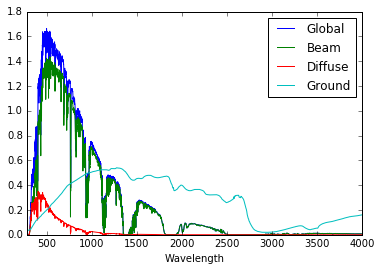

In [5]:
# solar spectrum data, calculated with SMARTS
SMARTS = pd.read_csv('smarts.txt', sep=' ')
SMARTS = SMARTS.set_index("Wavelength")
SMARTS.plot()

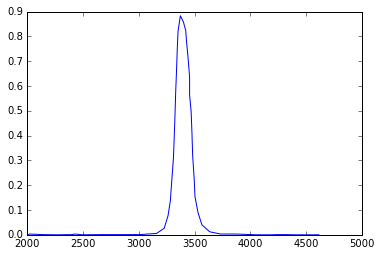

In [7]:
# filter transmission data, traced form graph on website
MWIR = pd.read_csv('pm_filter.csv')
MWIR = MWIR.set_index("Wavelength")
MWIR["Transmission"] /= 100
MWIR["Transmission"][MWIR["Transmission"] < 0] = 0
plt.plot(MWIR["Transmission"])

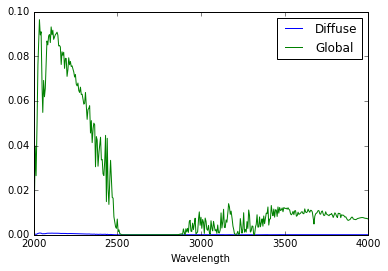

In [8]:
# interpolate solar spectrum to sampling every nm
SMARTS_int = pd.DataFrame()
SMARTS_int["Wavelength"] = np.arange(2000, 4001)
SMARTS_int["Diffuse"] = scipy.interpolate.interp1d(SMARTS.index, SMARTS["Diffuse"])(np.arange(2000,4001))
SMARTS_int["Global"] = scipy.interpolate.interp1d(SMARTS.index, SMARTS["Global"])(np.arange(2000,4001))
SMARTS_int = SMARTS_int.set_index("Wavelength")
SMARTS_int.plot()

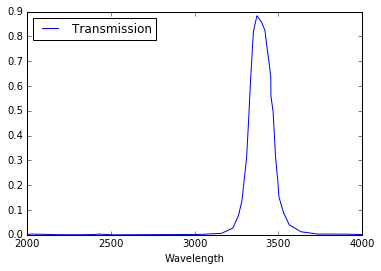

In [10]:
# interpolate filter to sampling every nm
MWIR_int = pd.DataFrame()
MWIR_int["Wavelength"] = SMARTS_int.index
MWIR_int["Transmission"] = scipy.interpolate.interp1d(MWIR.index, MWIR["Transmission"])(np.arange(2000,4001))
MWIR_int = MWIR_int.set_index("Wavelength")
MWIR_int.plot()

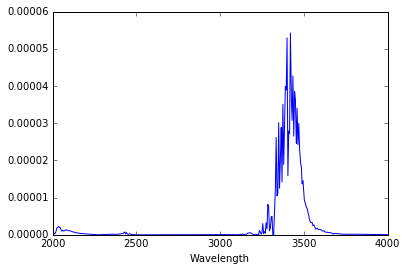

In [12]:
(MWIR_int["Transmission"] * SMARTS_int["Diffuse"]).plot()

In [16]:
pixel_area = 77e-6 ** 2
lens_area = np.pi * (2.6e-3)**2
lens_steradians = (1 - np.cos(np.deg2rad(33/32)))
# lens_steradians = 1
lens_efficiency = 0.8
photon_energy = 1.60218e-19 * (0.19732697 / (np.arange(2000., 4001)/1000.))# joules
exposure_time = 1./15
sensitivity = 450 # volts / watt
preamplifier_gain = 40
microvolts = 1e-6

In [21]:
watts_per_m2 = np.sum((MWIR_int["Transmission"] * SMARTS_int["Diffuse"]))
print("Watts per square meter: " + str(watts_per_m2))
watts_per_pixel = watts_per_m2 * lens_area * lens_steradians * lens_efficiency
print("Watts per pixel: " + str(watts_per_pixel))
microvolts_per_pixel = watts_per_pixel * sensitivity * preamplifier_gain / microvolts
print("Microvolts peer pixel: " + str(microvolts_per_pixel))

Watts per square meter: 0.00561371664943
Watts per pixel: 1.4526157832e-11
Microvolts peer pixel: 0.261470840977


In [1]:
h = 6.626e-34
c = 3.0e+8
k = 1.38e-23

def blackbody(wavelength, T):
    a = 2.0*h*c**2
    b = h*c/(wavelength*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) ) / 1e6 * np.pi
    return intensity

In [172]:
import jcamp

# absorbtivity of 5cm of methane at 150 mmHg pressure 
methane = jcamp.JCAMP_reader('/Users/loganw/Downloads/74-82-8-IR.jdx')
methane["x"] = 10000000/methane["x"] # convert to nm

# interpolate to 1nm sampling
methane_int = pd.DataFrame()
methane_int["Wavelength"] = range(2631, 4001)
methane_int["Transmission"] = scipy.interpolate.interp1d(methane["x"], methane["y"])(np.arange(2631,4001))
methane_int = methane_int.set_index("Wavelength")
methane_int.plot()

In [186]:
# what percentage change in power (assuming flat spectrum over bandpass filter) will we see with the presence of this much methane?
np.sum(methane_int["Transmission"] * MWIR_int["Transmission"][631:]) / np.sum(MWIR_int["Transmission"])

0.7310237250751941